In [4]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from esc_psf.math_module import xp, xcipy, ensure_np_array
from esc_psf import utils, wfe, iefc, dm
import esc_psf.esc_fraunhofer as esc

wavelength_c = 650e-9



In [2]:
wfe_data = utils.load_pickle('../data/example_wfe_data_1K.pkl')

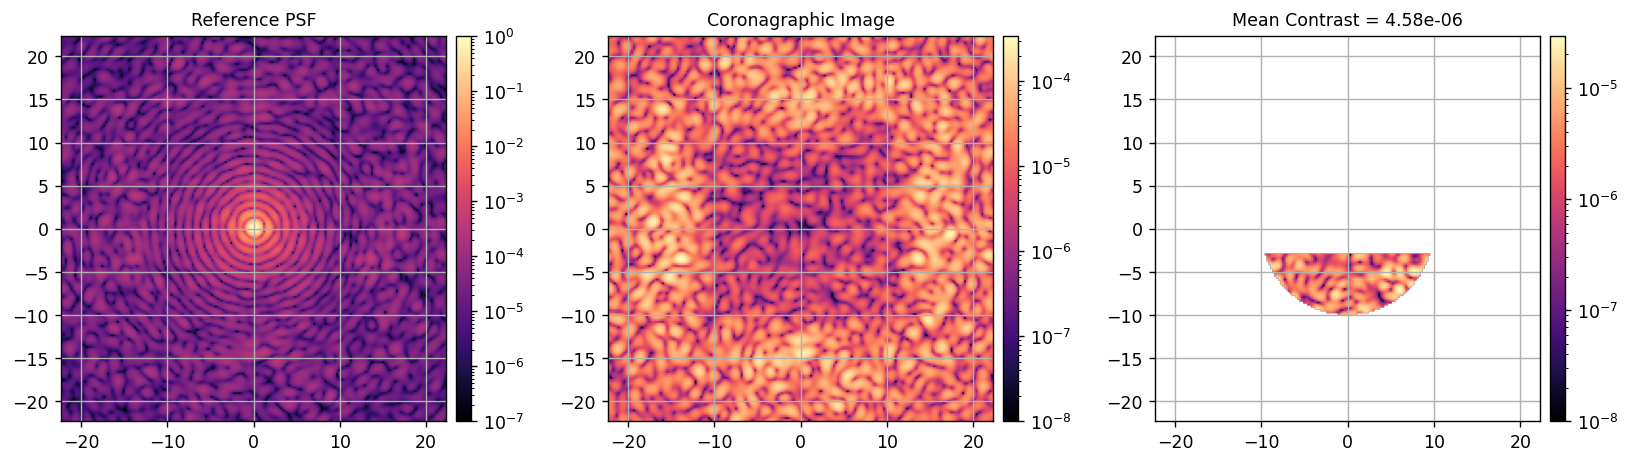

In [3]:
reload(esc)
M = esc.single(
    Nact=wfe_data['Nact'],
    total_pupil_diam=wfe_data['total_pupil_diam'],
    dm_beam_diam=wfe_data['dm_beam_diam'],
    act_spacing=wfe_data['act_spacing'], 
    dm_ref=wfe_data['DM_FLAT'],
    wavelength_c=500e-9, 
)
M.ncamsci = 200

M.PREFPM_AMP = wfe_data['PREFPM_AMP']
M.PREFPM_OPD = wfe_data['PREFPM_OPD']
M.POSTFPM_AMP = wfe_data['POSTFPM_AMP']
M.POSTFPM_OPD = wfe_data['POSTFPM_OPD']
M.RLS_AMP = wfe_data['RLS_AMP']
M.RLS_OPD = wfe_data['RLS_OPD']

iwa = 3
owa = 10
control_mask = utils.create_annular_focal_plane_mask(
    M.ncamsci, 
    M.camsci_pxscl_lamD, 
    iwa, 
    owa,  
    edge=iwa,
    rotation=90,
)

M.Imax_ref = 1
M.use_vortex = 0
ref_psf = M.snap_camsci()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = 1
camsci_im0 = M.snap_camsci()
mean_contrast = xp.mean(camsci_im0[control_mask])

utils.imshow(
    [ref_psf/M.Imax_ref, camsci_im0, camsci_im0*control_mask],
    titles=['Reference PSF', 'Coronagraphic Image', f'Mean Contrast = {mean_contrast:.2e}'], 
    pxscls=3*[M.camsci_pxscl_lamD],
    norms=[LogNorm(1e-7), LogNorm(1e-8), LogNorm(1e-8)],
    npix=[None, None, 200],
    grids=[0, 1, 1],
)


In [5]:
M.Nact

34

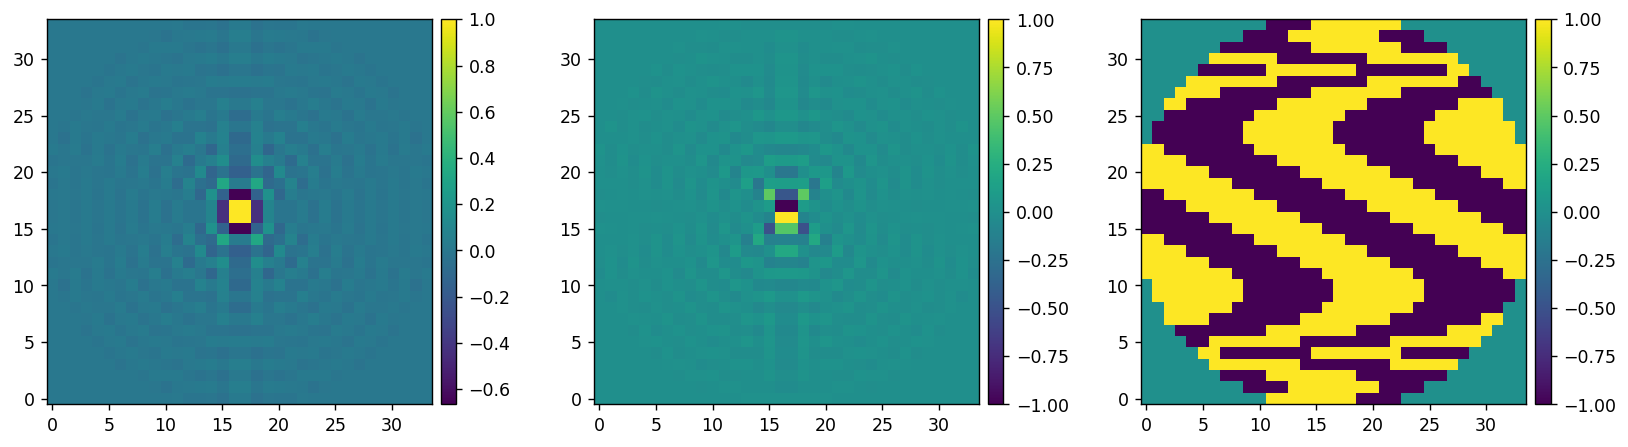

In [5]:
reload(utils)
reload(dm)
fourier_probes = dm.create_fourier_probes(
    M.dm_mask, 
    M.ncamsci, 
    M.camsci_pxscl_lamDc, 
    2, 
    15, 
    # iwa-1, 16, 
    rotation=90,
    use_weighting=True,
    nprobes=2,
)

calib_modes = dm.create_hadamard_modes(M.dm_mask)

utils.imshow([fourier_probes[0], fourier_probes[1], calib_modes[8]], cmaps=3*['viridis'])

Calibrating iEFC...
	Calibrated mode 1024/1024 in 82.580s
Calibration complete.


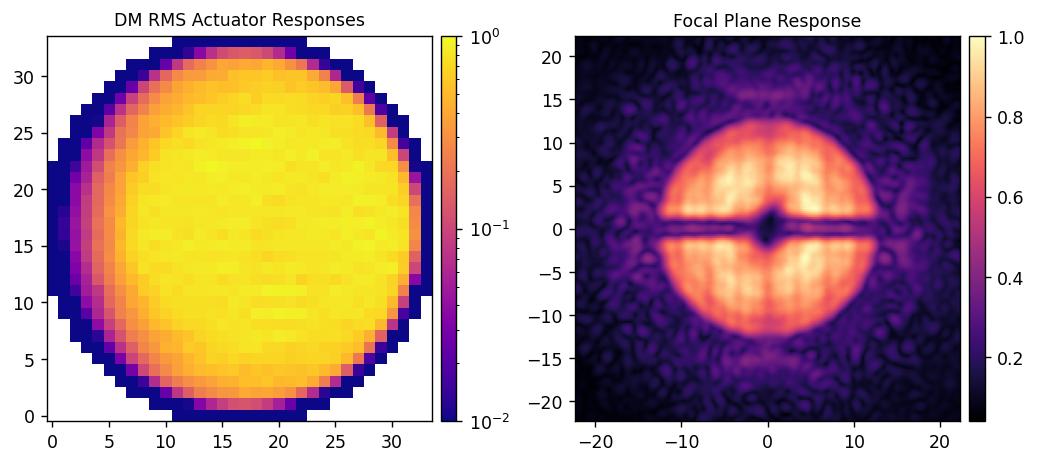

In [ ]:
reload(iefc)

jac, response_cube = iefc.calibrate(
    M, 
    control_mask, 
    1e-9, 
    fourier_probes, 
    1e-9,
    calib_modes[:], 
    channel=3,
    scale_factors=None, 
    plot_responses=True, 
)

In [10]:
jac = jac[0]

In [12]:
reload(utils)
cm20 = utils.beta_reg(jac, -2)
cm25 = utils.beta_reg(jac, -2.5)
# cm30 = utils.beta_reg(jac, -3)
# cm35 = utils.beta_reg(jac, -3.5)
# cm40 = utils.beta_reg(jac, -4)
cm45 = utils.beta_reg(jac, -4.5)
cm50 = utils.beta_reg(jac, -5)

In [13]:
jac.shape

(4020, 1024)

In [14]:
M.reset_dm()
iefc_data = {
    'images':[camsci_im0],
    'contrasts':[mean_contrast],
    'commands':[],
    'efields':[],
    'del_commands':[],
    'pixelscale':M.camsci_pxscl_lamDc,
    'control_mask':control_mask, 
}

Running iEFC...
	Closed-loop iteration 13 / 15


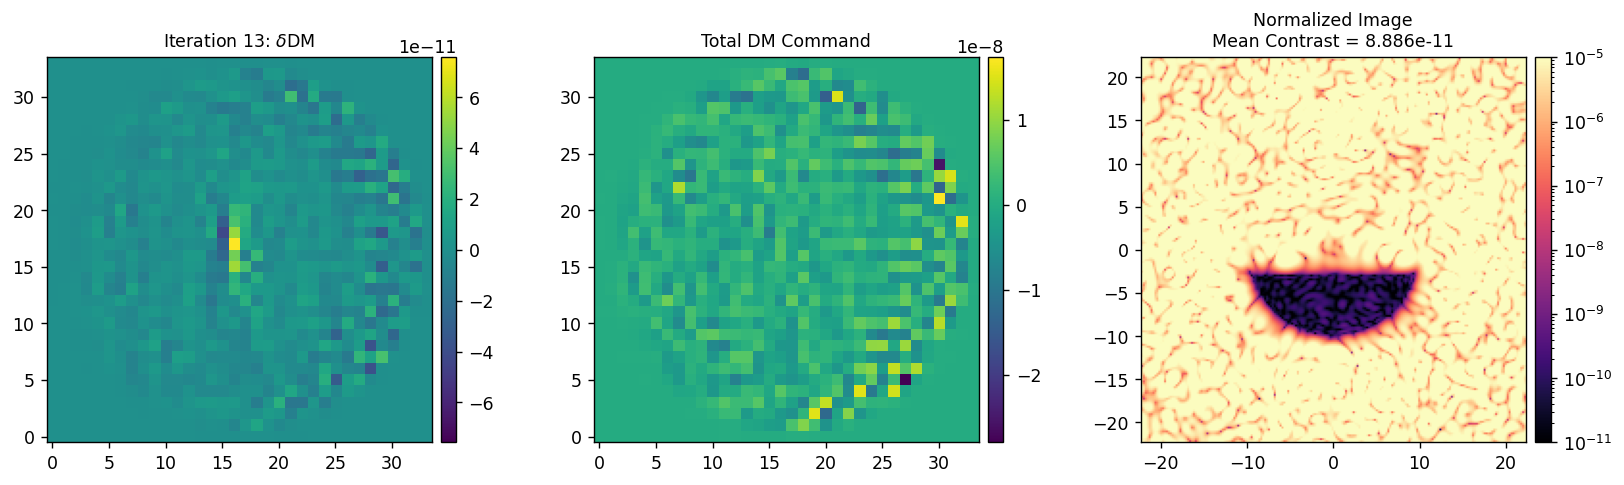

	Closed-loop iteration 14 / 15


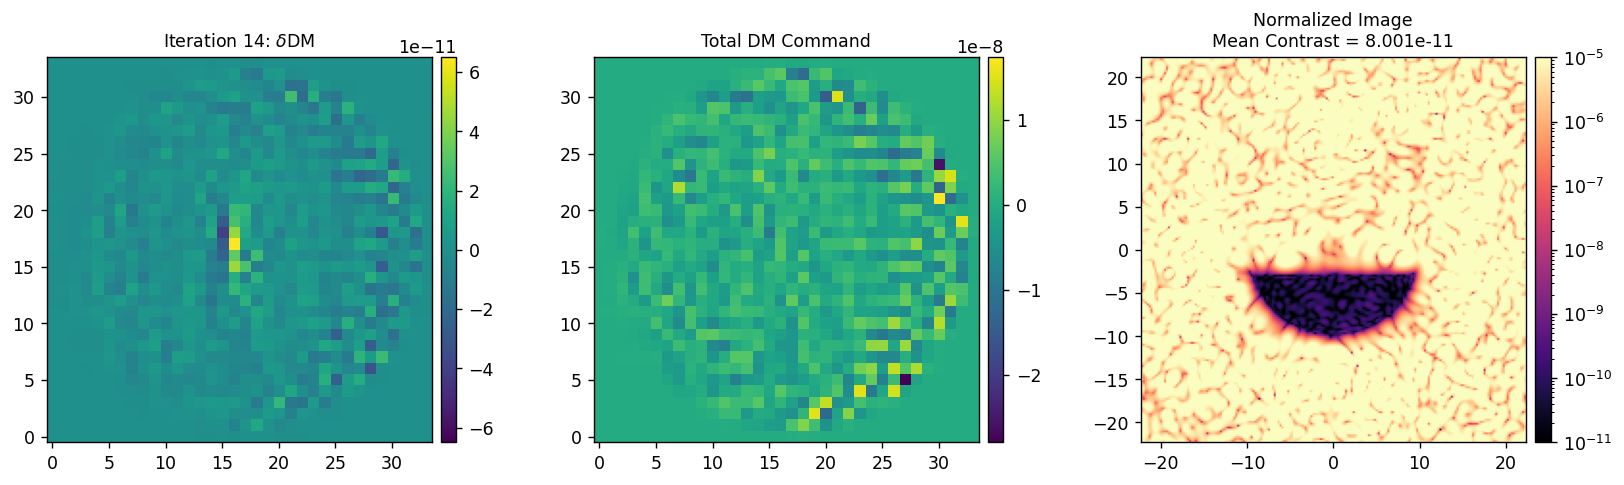

	Closed-loop iteration 15 / 15


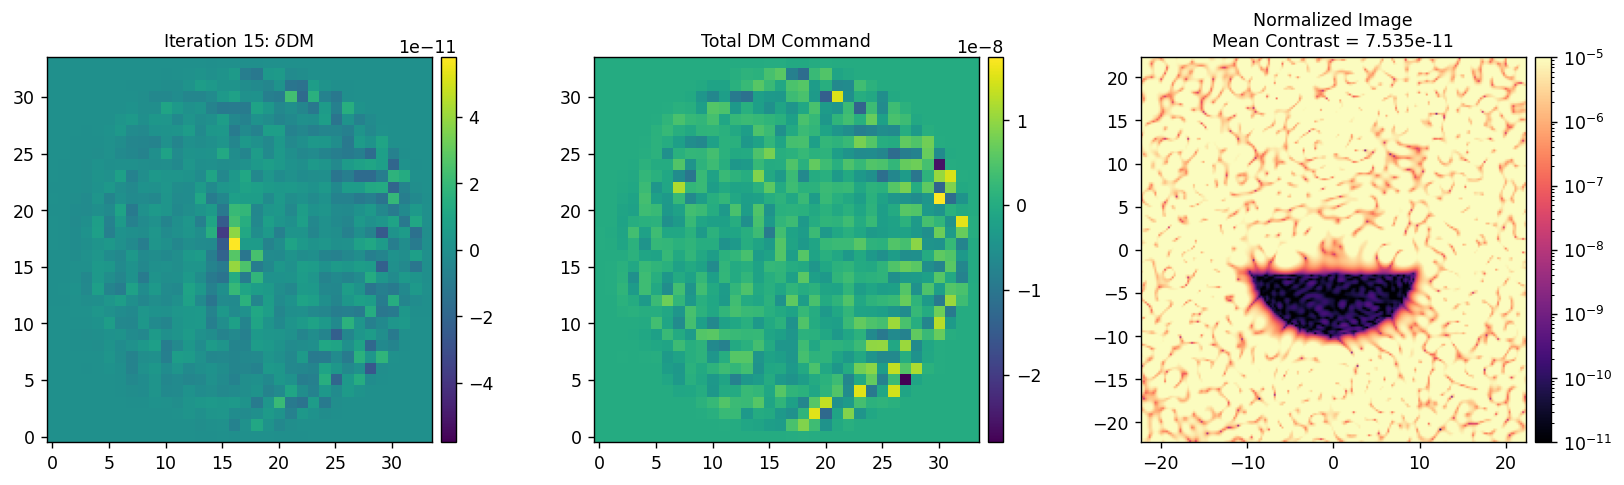

Closed loop for given control matrix completed in 3.030s.


In [20]:
reload(iefc)

iefc_data = iefc.run(
    M,
    iefc_data,
    # cm20,
    cm25,
    # cm40,
    # cm45,
    # cm50,
    fourier_probes, 
    1e-9, 
    calib_modes,
    control_mask,
    channel=3,
    num_iterations=3,
    gain=0.75, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    vmin=1e-11,
    plot_probes=False,
)